# CH07 RNN을 사용한 문장 생성 

## 언어 model -> 다양한 분야에 적용 가능 
## 언어 model -> 필연적인 것이 아니고 확률적으로 결정
## 언어 model: 훈련 모델 암기 x 단어의 출현 패턴을 학습 


In [2]:
import sys 
sys.path.append("..")
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size = 100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size =1, p=p)
            if (skip+ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
                
        return word_ids
            

In [1]:
import sys
sys.path.append("..")
from rnnlm_gen import RnnlmGen
from dataset2 import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N", "<unk>", "$"] # 숫자는 N 거의 출현하지 않는 단어를 unk로 
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', ".\n")
print(txt)

you constituency tricky capitol christmas disasters second spots porter shipbuilding lovely oversees spreads conception loses agency basir process occurred scandals taiwan theirs storage suddenly ryder specifically shipyard task pennzoil cable takeovers zero suburban active timing priority well tripled concluding expansion down operate durable busiest old-fashioned locations shouted realities lunch swapo routes diet nose lee utsumi burlington bancorp rich incentive asia relies reconciliation kelly screens sample various angels heroes working reeling definitive silent complain want maturing craig bottom expire theaters milk gelbart brunt discrimination audit stressed special-interest deciding shelves coast younkers definitely a.m. client members cater throw dubbed son families arguments


# Seq2seq
## time-series to time-series / Encoder-Decoder model 이라고도 불림 
## encoding => 부호화 decoding => 복호화 

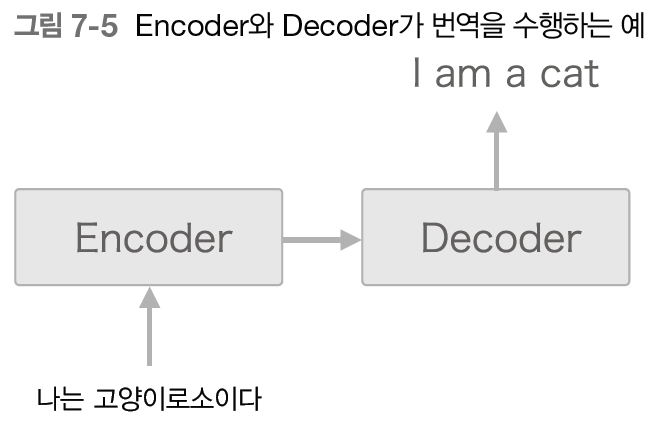 
### 번역할 대상언어는 '출발어', 번역된 결과를 '도착어'라고 함

### 인코딩이란? 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업!
### 디코딩=>  encoding 신경망+ LSTM h vecor 추가 

#### toy problem : 머신러닝을 평가하고자 만든 간단한 문제 

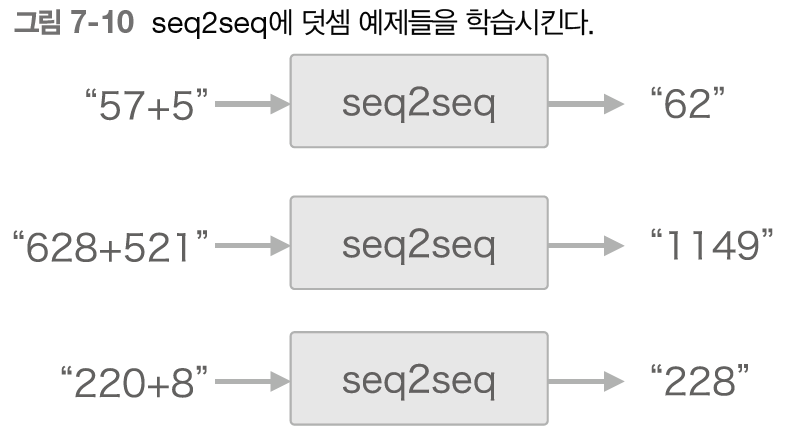

#### 가변길이 time-series => 공백문자에 대해 padding을 실시 

In [8]:
import sys 
sys.path.append("..")
from dataset2 import sequence
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt",seed=1984) # 문자의 ID 저장
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print("-"*50)
print(x_test.shape, t_test.shape)

print(x_train[0])
print("-"*50)
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
--------------------------------------------------
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
--------------------------------------------------
[ 6  0 11  7  5]
71+118 
_189 


# Encoder class 
## LSTM 계층 이용 (최종적으로 hidden-state h를 반환)
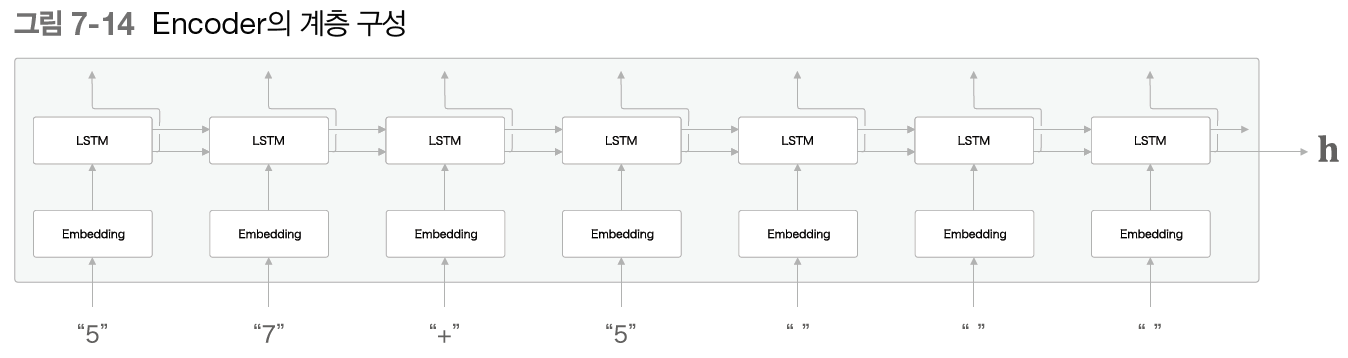

In [9]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype("f")
        lstm_Wx = (rn(D, 4*H)/ np.sqrt(D)).astype("f")
        lstm_b = np.zeros(4 * H).astype("f")
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False) # 은닉상태를 0으로 초기화 
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

In [10]:
def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]

def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh
    
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

# Decoder 클래스 
## 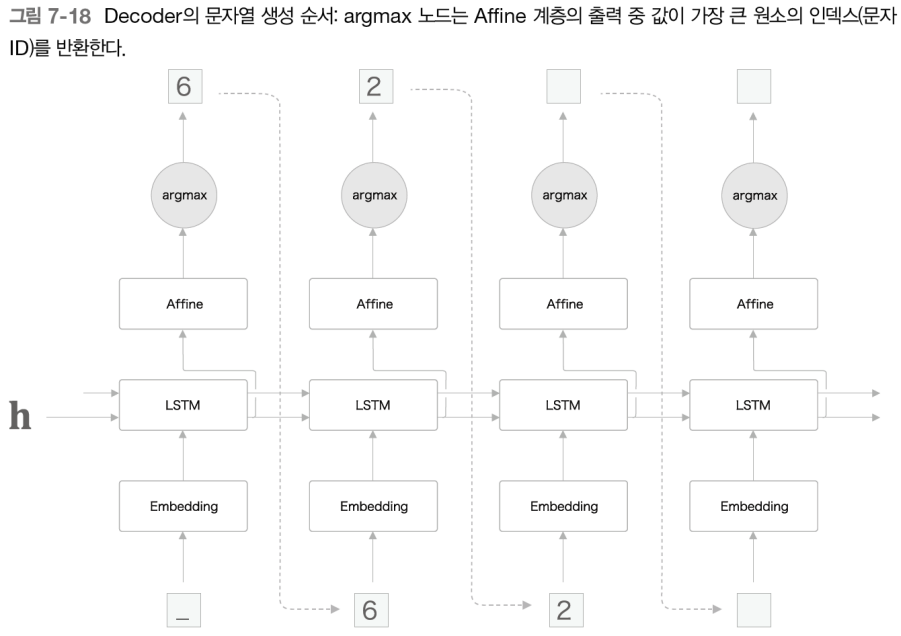


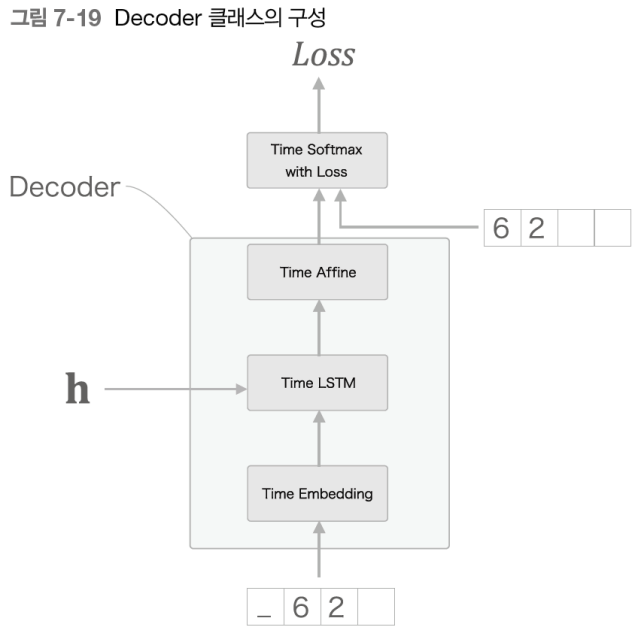

In [11]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H)/ np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V)/ np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self,grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
        

In [12]:
def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id 
    self.lstm.get_state(h)
    
    for _ in range(sample_size):
        x = np.array(sample_id).reshape((1, 1))
        out = self.embed.forward(x)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        
        sample_id = np.argmax(score.flatten())
        sampled.append(int(sample_id))
        
    return sampled

# Seq2seq
## Encoder + Time Softmax With Loss + Decoder
## Seq2seq => train set에서 미니배치 선택, 기울기 계산, 매개변수 갱신 

In [13]:
class Seq2eq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H - vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1 ):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled
        

NameError: name 'BaseModel' is not defined

## 성능 평가 : 정답률 (맞으면 1, 틀리면 0)

In [19]:
import sys 
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from dataset2 import sequence 
from common.optimizer import Adam
from common.trainer  import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

# 데이터 로드
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델/옵티마이져/트레이너 생성

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer =Trainer(model, optimizer)


acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
               batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                  id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 %.3f%%" % (acc *100))



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 18[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 19[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---

| 에폭 8 |  반복 341 / 351 | 시간 23[s] | 손실 1.01
Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1108
---
Q 582+84 
T 666 
X 660 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
X 411 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1009
---
Q 830+597
T 1427
X 1410
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 207 
---
검증 정확도 3.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 1.00
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 6[s] | 손실 1.00
| 에폭 9 |  반복 141 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 8[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 9[s] | 손실 0.98
| 에폭 9 |  반복 201 / 351 | 시간 10[s] | 손실 0.99
| 에폭 9 |  반복 221 / 351 | 시간 11[s] | 손실 1.00
| 에폭 9 |  반복 241 / 351 | 시간 12[s] | 손실 0.98
| 에폭 9 |  반복 261 / 351 | 시간 12[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 13[s] | 손실 0.99
| 에폭 9 |  반복 301 /

| 에폭 16 |  반복 141 / 351 | 시간 8[s] | 손실 0.87
| 에폭 16 |  반복 161 / 351 | 시간 9[s] | 손실 0.86
| 에폭 16 |  반복 181 / 351 | 시간 10[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 11[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 13[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 14[s] | 손실 0.86
| 에폭 16 |  반복 261 / 351 | 시간 15[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 16[s] | 손실 0.87
| 에폭 16 |  반복 301 / 351 | 시간 18[s] | 손실 0.85
| 에폭 16 |  반복 321 / 351 | 시간 19[s] | 손실 0.91
| 에폭 16 |  반복 341 / 351 | 시간 20[s] | 손실 0.87
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1124
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 6.880%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.85
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.87
| 에폭 17 |  반복 61 / 351 | 시간 3[s] | 손실 0.87
| 에폭 17 |  반복 81 / 351 | 시간 4[s] | 손실 0.85

검증 정확도 4.800%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.80
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.83
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.81
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.80
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.79
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.76
| 에폭 24 |  반복 121 / 351 | 시간 6[s] | 손실 0.77
| 에폭 24 |  반복 141 / 351 | 시간 7[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 8[s] | 손실 0.78
| 에폭 24 |  반복 181 / 351 | 시간 9[s] | 손실 0.81
| 에폭 24 |  반복 201 / 351 | 시간 11[s] | 손실 0.80
| 에폭 24 |  반복 221 / 351 | 시간 12[s] | 손실 0.79
| 에폭 24 |  반복 241 / 351 | 시간 13[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 14[s] | 손실 0.79
| 에폭 24 |  반복 281 / 351 | 시간 15[s] | 손실 0.78
| 에폭 24 |  반복 301 / 351 | 시간 17[s] | 손실 0.78
| 에폭 24 |  반복 321 / 351 | 시간 18[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 19[s] | 손실 0.80
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 157 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1049


### 정답률이 10% => 다소 낮은 편 개선이 필요!

# Seq2seq의 개선 
## 1. 입력 데이터의 반전 

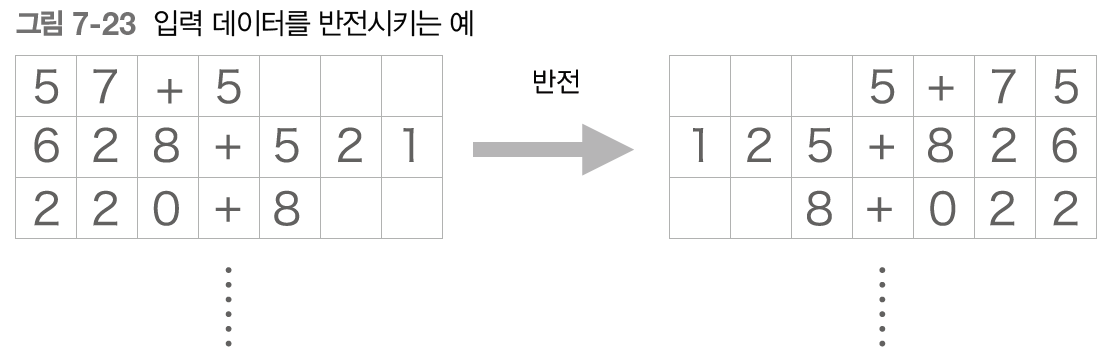

### 학습의 진행과 속도가 향상됨 (기울기 전파가 원활?)

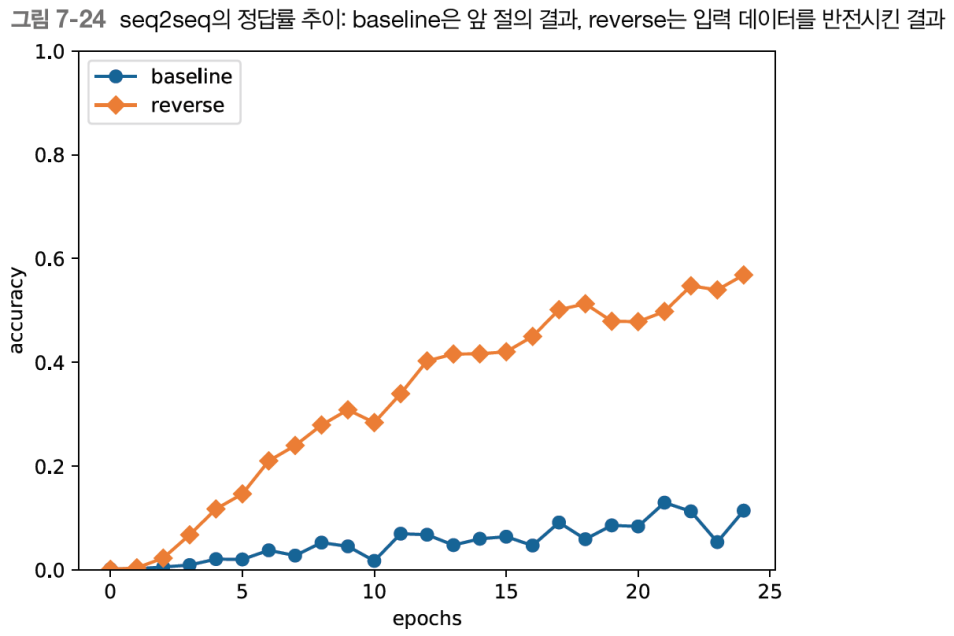

## 2. 엿보기(Peeky)
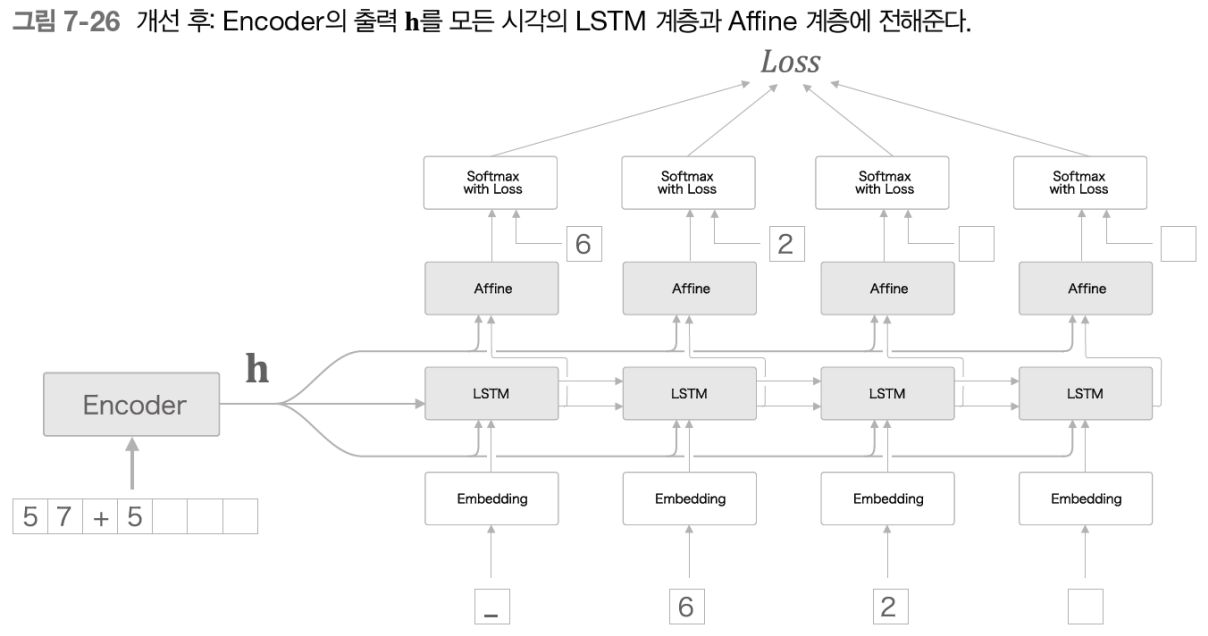


# 2가지 방법을 조합한 결과
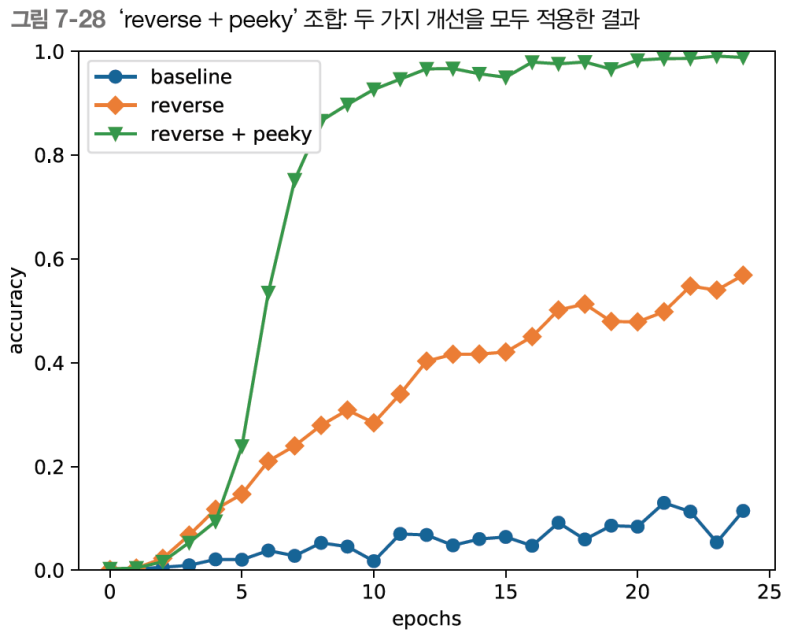

In [20]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V)/ np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
        
    
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis = 2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis= 2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score

In [22]:
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.ecoder.grads + self.decoder.grads
        

In [24]:
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

NameError: name 'TimeEmbedding' is not defined

In [25]:
import sys 
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from dataset2 import sequence 
from common.optimizer import Adam
from common.trainer  import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

# 데이터 로드
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델/옵티마이져/트레이너 생성

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer =Trainer(model, optimizer)


acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
               batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                  id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 %.3f%%" % (acc *100))



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.49
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 19[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 20[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 21[s] | 손실 1.73
Q 77+85  
T 162 
X 107 
---
Q 975+164
T 1139
X 1011
---
Q 582+84 
T 666 
X 103 
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 103 
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1011
--

| 에폭 8 |  반복 321 / 351 | 시간 19[s] | 손실 0.73
| 에폭 8 |  반복 341 / 351 | 시간 20[s] | 손실 0.71
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1037
---
Q 830+597
T 1427
X 1437
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 231 
---
검증 정확도 12.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.70
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.70
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.70
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.70
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.69
| 에폭 9 |  반복 121 / 351 | 시간 7[s] | 손실 0.69
| 에폭 9 |  반복 141 / 351 | 시간 8[s] | 손실 0.68
| 에폭 9 |  반복 161 / 351 | 시간 9[s] | 손실 0.68
| 에폭 9 |  반복 181 / 351 | 시간 10[s] | 손실 0.67
| 에폭 9 |  반복 201 / 351 | 시간 11[s] | 손실 0.68
| 에폭 9 |  반복 221 / 351 | 시간 12[s] | 손실 0.67
| 에폭 9 |  반복 241 / 351 | 시간 14[s] | 손실 0.67
| 에폭 9 |  반복 261 / 351 | 시간 15[s] | 손실 0.67
| 에폭 9 |  반복 281

| 에폭 16 |  반복 101 / 351 | 시간 7[s] | 손실 0.44
| 에폭 16 |  반복 121 / 351 | 시간 8[s] | 손실 0.43
| 에폭 16 |  반복 141 / 351 | 시간 10[s] | 손실 0.44
| 에폭 16 |  반복 161 / 351 | 시간 11[s] | 손실 0.43
| 에폭 16 |  반복 181 / 351 | 시간 13[s] | 손실 0.43
| 에폭 16 |  반복 201 / 351 | 시간 15[s] | 손실 0.42
| 에폭 16 |  반복 221 / 351 | 시간 16[s] | 손실 0.43
| 에폭 16 |  반복 241 / 351 | 시간 17[s] | 손실 0.44
| 에폭 16 |  반복 261 / 351 | 시간 20[s] | 손실 0.43
| 에폭 16 |  반복 281 / 351 | 시간 22[s] | 손실 0.42
| 에폭 16 |  반복 301 / 351 | 시간 23[s] | 손실 0.43
| 에폭 16 |  반복 321 / 351 | 시간 25[s] | 손실 0.45
| 에폭 16 |  반복 341 / 351 | 시간 26[s] | 손실 0.44
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1048
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 31.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.41
| 에폭 17 |  반복 41 / 351 | 시간 3[s] | 손실

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1436
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 70.680%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.18
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.18
| 에폭 24 |  반복 61 / 351 | 시간 4[s] | 손실 0.18
| 에폭 24 |  반복 81 / 351 | 시간 5[s] | 손실 0.17
| 에폭 24 |  반복 101 / 351 | 시간 6[s] | 손실 0.18
| 에폭 24 |  반복 121 / 351 | 시간 7[s] | 손실 0.17
| 에폭 24 |  반복 141 / 351 | 시간 9[s] | 손실 0.17
| 에폭 24 |  반복 161 / 351 | 시간 10[s] | 손실 0.17
| 에폭 24 |  반복 181 / 351 | 시간 11[s] | 손실 0.18
| 에폭 24 |  반복 201 / 351 | 시간 13[s] | 손실 0.18
| 에폭 24 |  반복 221 / 351 | 시간 14[s] | 손실 0.17
| 에폭 24 |  반복 241 / 351 | 시간 15[s] | 손실 0.18
| 에폭 24 |  반복 261 / 351 | 시간 16[s] | 손실 0.18
| 에폭 24 |  반복 281 / 351 | 시간 18[s] | 손실 0.17
| 에폭 24 |  반복 301 / 351 | 시간 19[s] | 손실 0.17

# Seq2seq의 application
## 챗봇: 사람과 컴퓨터가 텍스트로 대화를 나누는 프로그램 

## 이미지캡셔닝

# 정리
## 1. RNN을 이용한 언어모델은 새로운 문장을 생성할 수 있음 
## 2. 문장 생성시 확률분포에서 sampling하는 과정을 반복 
## 3. RNN 2개 조합 => Seq2seq model
## 4.Encoder 입력문을 부호화, Decoder는 받은 부호를 다시 복호화
## 5. Seq2seq model은 reversing과 Peeky 기법을 통해 성능 및 속도를 향상시킬 수 있음
## 6. 챗봇 및 이미지 캡셔닝 등등 다양한 분야에 적용 가능 